**To download and untar the dataset in colab:**

```bash
! mkdir -P /content/drive/MyDrive/datasets/deepsig
! wget -P /content/drive/MyDrive/datasets/deepsig https://f002.backblazeb2.com/file/deepsig-datasets/2016.10/RML2016.10b.tar.bz2?Authorization=3_20221227213905_2c795ffc54e9046c69c5217c_469e51be5cab6f465d8a532240da083f077ea3dc_002_20221227223905_0027_dnld
! mv /content/drive/MyDrive/datasets/deepsig/RML2016.10b.tar.bz2?Authorization=3_20221227213905_2c795ffc54e9046c69c5217c_469e51be5cab6f465d8a532240da083f077ea3dc_002_20221227223905_0027_dnld /content/drive/MyDrive/datasets/deepsig/RML2016.10b.tar.bz2
! tar -xvf /content/drive/MyDrive/datasets/deepsig/RML2016.10b.tar.bz2 -C /content/drive/MyDrive/datasets/deepsig/RML2016.10b
! rm /content/drive/MyDrive/datasets/deepsig/RML2016.10b.tar.bz2
```

> Note : 
> The link will not work, you will have to request a link from the website.

# Imports and Constants

In [5]:
import pickle

import numpy as np
import scipy as sci
from scipy.integrate import cumulative_trapezoid

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import gc

ROOT = '/kaggle/input/rml2016'
DAT = ROOT + '/RML2016.10b.dat'

# Loading and exploring the data

In [6]:
# from https://github.com/radioML/examples/blob/master/modulation_recognition/RML2016.10a_VTCNN2_example.ipynb
# modified for python 3
Xd = pickle.load(open(DAT, 'rb'), encoding='latin1')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
del Xd, snrs, mods
X = np.vstack(X)
y = np.array(lbl)
del lbl
gc.collect()

X.shape, y.shape

((1200000, 2, 128), (1200000, 2))

In [7]:
# The labels
print(f'{np.unique(y[:,0],return_counts=True)}\n\n\
{np.unique(y[:,1],return_counts=True)}')

(array(['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16',
       'QAM64', 'QPSK', 'WBFM'], dtype='<U21'), array([120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000,
       120000, 120000]))

(array(['-10', '-12', '-14', '-16', '-18', '-2', '-20', '-4', '-6', '-8',
       '0', '10', '12', '14', '16', '18', '2', '4', '6', '8'],
      dtype='<U21'), array([60000, 60000, 60000, 60000, 60000, 60000, 60000, 60000, 60000,
       60000, 60000, 60000, 60000, 60000, 60000, 60000, 60000, 60000,
       60000, 60000]))


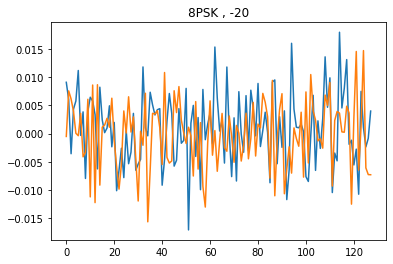

In [39]:
plt.plot(X[0,0])
plt.plot(X[0,1])
plt.title(f'{y[0,0]} , {y[0,1]}')
plt.show()

## Signal derivative

In [8]:
from plotly.graph_objs import Line
d_np = np.gradient(X[0,0])

lines=[d_np,X[0,0]]

t = np.linspace(0,127,128)

fig = go.Figure()
fig.add_trace(go.Line(x=t,y=lines[0],name=f'derivative'))
fig.add_trace(go.Line(x=t,y=lines[1],name=f'original signal'))

fig.show()

/opt/conda/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




## Signal Integral

In [9]:
i_ct = cumulative_trapezoid(X[0,0])

lines=[i_ct,X[0,0]]

t = np.linspace(0,127,128)

fig = go.Figure()
fig.add_trace(go.Line(x=t,y=lines[0],name=f'cumulative trapezoid'))

fig.add_trace(go.Line(x=t,y=lines[1],name=f'original signal'))

fig.show()

# Creating Feature Spaces

Possible feature spaces:

1. raw signal
2. derivative
3. integration
4. raw and derivative
5. raw and integration
6. derivative and integration
7. raw and derivative and integration


In [36]:
'''''X_diff = np.gradient(X,axis=-1)
X_int = np.zeros_like(X)
X_int[:,:,:-1] = np.array(cumulative_trapezoid(X))

X_raw_diff = np.concatenate((X,X_diff),axis=1)
X_raw_int = np.concatenate((X,X_int),axis=1)
X_diff_int = np.concatenate((X_diff,X_int),axis=1)

X_all = np.concatenate((X,X_diff,X_int),axis=1)

print(f'\
Shapes\n\
X_raw: {X.shape}\n\
X_diff: {X_diff.shape}\n\
X_int: {X_int.shape}\n\n\
X_raw_diff: {X_raw_diff.shape}\n\
X_raw_int: {X_raw_int.shape}\n\
X_diff_int: {X_diff_int.shape}\n\n\
X_all: {X_all.shape}')'''''

"''X_diff = np.gradient(X,axis=-1)\nX_int = np.zeros_like(X)\nX_int[:,:,:-1] = np.array(cumulative_trapezoid(X))\n\nX_raw_diff = np.concatenate((X,X_diff),axis=1)\nX_raw_int = np.concatenate((X,X_int),axis=1)\nX_diff_int = np.concatenate((X_diff,X_int),axis=1)\n\nX_all = np.concatenate((X,X_diff,X_int),axis=1)\n\nprint(f'Shapes\nX_raw: {X.shape}\nX_diff: {X_diff.shape}\nX_int: {X_int.shape}\n\nX_raw_diff: {X_raw_diff.shape}\nX_raw_int: {X_raw_int.shape}\nX_diff_int: {X_diff_int.shape}\n\nX_all: {X_all.shape}')"

In [39]:
'''''del X_diff
del X_int

del X_raw_diff
del X_raw_int
del X_diff_int

del X_all'''''

"''del X_diff\ndel X_int\n\ndel X_raw_diff\ndel X_raw_int\ndel X_diff_int\n\ndel X_all"

# Data Splitting

In [10]:
def split(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state =1, stratify = y[:,0])
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.05, random_state =1, stratify = y_train[:,0])
    return x_train, x_val, x_test, y_train, y_val, y_test

# Models

## Hyperparameters

In [27]:
EPOCHS = 100
PATIENCE = 6
LEARNING_RATE = 0.0009

## CNN model
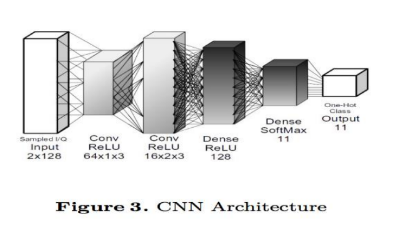

In [ ]:
def create_cnn(name,cnn_input_shape):
    cnn_model = keras.Sequential([
        layers.Conv2D(64,
                    kernel_size=3,
                    activation='relu',
                      padding='same',
                    input_shape=cnn_input_shape),
        layers.Conv2D(16,
                     kernel_size=3,
                      strides=2,
                      padding='same',
                     activation='relu'),
        layers.Flatten(),
        layers.Dense(128,activation='relu'),
        layers.Dense(10,activation='softmax'),
    ],name=name)

    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    loss = keras.losses.CategoricalCrossentropy()
    cnn_model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

    print(cnn_model.summary())
    return cnn_model
    
# TODO: questions: 
# is it conv1D
# 1. Padding?
# 2. what is x1  and x2 in 2nd and 3rd layer? kernel size or number of Conv?

In [12]:
x = X
cnn_model = create_cnn("cnn_2_ch",x.shape[1:]+(1,))

NameError: name 'create_cnn' is not defined

In [28]:
values = np.linspace(0.00001,LEARNING_RATE,20)[::-1]
boundaries = np.linspace(5, 100,19)[:values.shape[0]-1].astype(np.int32)

scheduler = keras.optimizers.schedules.PiecewiseConstantDecay(
    list(boundaries), list(values))

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience = PATIENCE, mode='min')

def configure_checkpoints(path):
    return keras.callbacks.ModelCheckpoint(
        filepath=path,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True)

In [30]:
def train_and_plot(model,checkpoint_path,x_train,y_train,x_val,y_val,epochs=EPOCHS):
    checkpoint = configure_checkpoints(checkpoint_path)
    history=model.fit(
        x=np.array(x_train),
        y=y_train,
        epochs=epochs,
        validation_data=(np.array(x_val),y_val),
        callbacks=[lr_scheduler,checkpoint,early_stopping]
    )

    num=len(history.history['loss'])

    plt.plot(range(num),history.history['loss'],label = 'training loss')
    plt.plot(range(num),history.history['val_loss'],label = 'validation loss')

    plt.legend()

    plt.xlabel("Epochs ")
    plt.ylabel('Loss')

    plt.figure()

    plt.plot(range(num),history.history['accuracy'],label = 'training accuracy')
    plt.plot(range(num),history.history['val_accuracy'],label = 'validation accuracy')

    plt.legend()
    plt.xlabel("Epochs ")
    return history
def train_and_plot2(model,checkpoint_path,x_train,y_train,x_val,y_val,epochs=EPOCHS):
    checkpoint = configure_checkpoints(checkpoint_path)
    history=model.fit(
        x=np.array(x_train),
        y=y_train,
        epochs=epochs,
        validation_data=(np.array(x_val),y_val),
        callbacks=[lr_scheduler,checkpoint]
    )

    num=len(history.history['loss'])

    plt.plot(range(num),history.history['loss'],label = 'training loss')
    plt.plot(range(num),history.history['val_loss'],label = 'validation loss')

    plt.legend()

    plt.xlabel("Epochs ")
    plt.ylabel('Loss')

    plt.figure()

    plt.plot(range(num),history.history['accuracy'],label = 'training accuracy')
    plt.plot(range(num),history.history['val_accuracy'],label = 'validation accuracy')

    plt.legend()
    plt.xlabel("Epochs ")
    return history

In [13]:
x_train, x_val, x_test, y_train, y_val, y_test = split(x,y)


In [28]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(y_test[:,0].reshape(-1,1))
y_test_encoded = encoder.transform(y_test[:,0].reshape(-1,1))
y_train_encoded = encoder.transform(y_train[:,0].reshape(-1,1))
y_val_encoded = encoder.transform(y_val[:,0].reshape(-1,1))
y_test_encoded.shape

(360000, 10)

In [ ]:
cnn_history = train_and_plot(
    cnn_model,
    "/kaggle/working/checkpoints/cnn",
    x_train.reshape(x_train.shape+(1,)),
    y_train_encoded,
    x_val.reshape(x_val.shape+(1,)),
    y_val_encoded,
    epochs=EPOCHS
)
del x_train
cnn_model.load_weights("/kaggle/working/checkpoints/cnn")
cnn_model.evaluate(x_val.reshape(x_val.shape+(1,)),y_val_encoded)

In [ ]:
# cnn_model.load_weights("/kaggle/working/checkpoints/cnn")
cnn_model.evaluate(x_val.reshape(x_val.shape+(1,)),y_val_encoded)

## Test Results

In [31]:
def eval_model(model,x,y,y_encoded):
#     print(model.evaluate(x.reshape(x.shape+(1,)),y_encoded))
    y_pred = model.predict(x.reshape(x.shape+(1,)))
    y_pred = np.argmax(y_pred,axis = -1)
    y_numbers = np.argmax(y_encoded,axis=-1)
    
    target_names = np.unique(y[:,0])
    labels = target_names
    tick_marks = np.arange(len(labels))

    print(classification_report(y_numbers, y_pred, target_names=target_names))
    
    cm = tf.math.confusion_matrix(y_numbers,y_pred).numpy().astype(np.int64)
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=3)
    sns.heatmap(cm,annot=True)
    plt.xticks(tick_marks, labels, rotation= 45)
    plt.yticks(tick_marks, labels, rotation=-45)
    
    plt.figure()
    snrs = np.unique(y[:,1])
    
    accuracies = np.zeros_like(snrs,dtype=np.float32)
    for i, snr in enumerate(snrs):
        idx = y[:,1] == snr
        cm = tf.math.confusion_matrix(y_numbers[idx],y_pred[idx]).numpy().astype(np.int64)
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=3)

        sns.heatmap(cm,annot=True)
        plt.title(f"SNR = {snr}")
        plt.xticks(tick_marks, labels, rotation= 45)
        plt.yticks(tick_marks, labels, rotation=-45)
        plt.show()
        plt.figure()
        accuracies[i] = np.count_nonzero(y_numbers[idx] == y_pred[idx]) / y_pred[idx].shape[0]
    
    plt.plot(snrs,np.around(accuracies * 100,2))
    plt.xlabel('SNR')
    plt.ylabel("Accuracy")
    plt.show()
def eval_model_lstm(model,x,y,y_encoded):
#     print(model.evaluate(x.reshape(x.shape+(1,)),y_encoded))
    y_pred = model.predict(x.reshape(x.shape))
    y_pred = np.argmax(y_pred,axis = -1)
    y_numbers = np.argmax(y_encoded,axis=-1)
    
    target_names = np.unique(y[:,0])
    labels = target_names
    tick_marks = np.arange(len(labels))

    print(classification_report(y_numbers, y_pred, target_names=target_names))
    
    cm = tf.math.confusion_matrix(y_numbers,y_pred).numpy().astype(np.int64)
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=3)
    sns.heatmap(cm,annot=True)
    plt.xticks(tick_marks, labels, rotation= 45)
    plt.yticks(tick_marks, labels, rotation=-45)
    
    plt.figure()
    snrs = np.unique(y[:,1])
    
    accuracies = np.zeros_like(snrs,dtype=np.float32)
    for i, snr in enumerate(snrs):
        idx = y[:,1] == snr
        cm = tf.math.confusion_matrix(y_numbers[idx],y_pred[idx]).numpy().astype(np.int64)
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=3)

        sns.heatmap(cm,annot=True)
        plt.title(f"SNR = {snr}")
        plt.xticks(tick_marks, labels, rotation= 45)
        plt.yticks(tick_marks, labels, rotation=-45)
        plt.show()
        plt.figure()
        accuracies[i] = np.count_nonzero(y_numbers[idx] == y_pred[idx]) / y_pred[idx].shape[0]
    
    plt.plot(snrs,np.around(accuracies * 100,2))
    plt.xlabel('SNR')
    plt.ylabel("Accuracy")
    plt.show()

In [ ]:
eval_model(cnn_model,x_test,y_test,y_test_encoded)

### CNN on X diff

In [ ]:
x = np.gradient(X,axis=-1)
cnn_diff_model = create_cnn("cnn_diff",x.shape[1:]+(1,))

In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test = split(x,y)
del x

In [ ]:
cnn_diff_history = train_and_plot(
    cnn_diff_model,
    "/kaggle/working/checkpoints/cnn",
    x_train.reshape(x_train.shape+(1,)),
    y_train_encoded,
    x_val.reshape(x_val.shape+(1,)),
    y_val_encoded,
    epochs=EPOCHS
)
del x_train

cnn_diff_model.load_weights("/kaggle/working/checkpoints/cnn")
cnn_diff_model.evaluate(x_val.reshape(x_val.shape+(1,)),y_val_encoded)

In [ ]:
eval_model(cnn_diff_model,x_test,y_test,y_test_encoded)

# LSTM 

In [14]:
#model

def create_lstm1(size):


    model = keras.Sequential()
    model.add(keras.layers.LSTM(22, input_shape=x.shape[1:]))
    model.add(keras.layers.Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model
def create_lstm(size):


    model = keras.Sequential()
    model.add(keras.layers.LSTM(128, input_shape=x.shape[1:]))
 

    # for units in [128,128,64,32]:

    # model.add(Dense(units,activation='relu'))

    # model.add(Dropout(0.2))
    model.add(keras.layers.Dense(64,activation='relu'))
    model.add(keras.layers.Dense(32,activation='relu'))

    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model
def create_lstm2(size):


    model = keras.Sequential()
    model.add(keras.layers.LSTM(256, input_shape=x.shape[1:]))
 

    # for units in [128,128,64,32]:

    # model.add(Dense(units,activation='relu'))

    # model.add(Dropout(0.2))
    model.add(keras.layers.Dense(128,activation='relu'))
    model.add(keras.layers.Dense(64,activation='relu'))
    model.add(keras.layers.Dense(32,activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model


In [25]:
size=str(x.shape[1:]+(1,))
print(size[1:-1])
lstm=create_lstm1(x.shape[1:])

2, 128, 1
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 22)                13288     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                230       
Total params: 13,518
Trainable params: 13,518
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/200

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 109s 4ms/step - loss: 2.0300 - accuracy: 0.2122 - val_loss: 2.0047 - val_accuracy: 0.2207
Epoch 2/200

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 108s 4ms/step - loss: 1.9664 - accuracy: 0.2378 - val_loss: 1.9330 - val_accuracy: 0.2465
Epoch 3/200

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 108s 4ms/step - loss: 1.8856 - accuracy: 0.2645 - val_loss: 1.8532 - val_accuracy: 0.2749
Epoch 4/200

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 108s 4ms/step - loss: 1.8199 - accuracy: 0.2827 - val_loss: 1.8034 - val_a

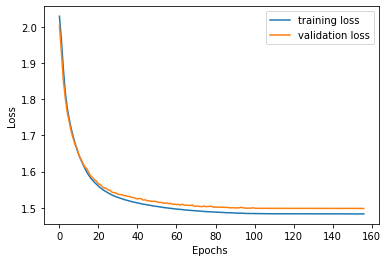

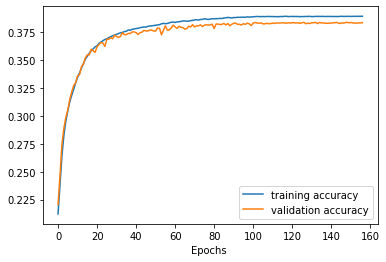

In [32]:
hist= train_and_plot(
    lstm,
    "/kaggle/working/checkpoints/lstm",
    x_train.reshape(x_train.shape),
    y_train_encoded,
    x_val.reshape(x_val.shape),
    y_val_encoded,
    epochs=2*EPOCHS
)

In [13]:
lstm1=create_lstm(x.shape[1:])

2023-01-10 23:17:50.511943: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 142,250
Trainable params: 142,250
Non-trainable params: 0
_________________________________________________________________
None


2023-01-10 23:20:20.624036: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 190s 7ms/step - loss: 1.9743 - accuracy: 0.2303 - val_loss: 1.8714 - val_accuracy: 0.2649
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 184s 7ms/step - loss: 1.8225 - accuracy: 0.2802 - val_loss: 1.7666 - val_accuracy: 0.2922
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 192s 8ms/step - loss: 1.6818 - accuracy: 0.3134 - val_loss: 1.5635 - val_accuracy: 0.3413
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 187s 8ms/step - loss: 1.5447 - accuracy: 0.3498 - val_loss: 1.4732 - val_a

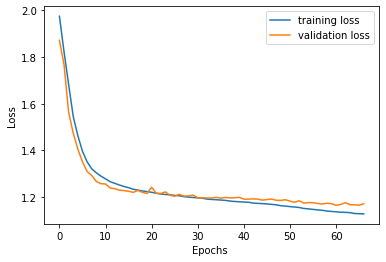

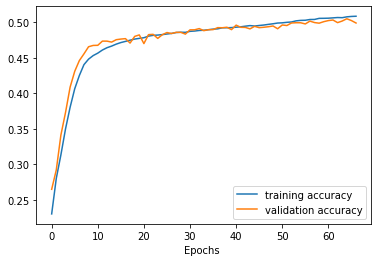

In [23]:
hist1= train_and_plot(
    lstm1,
    "/kaggle/working/checkpoints/lstm",
    x_train.reshape(x_train.shape),
    y_train_encoded,
    x_val.reshape(x_val.shape),
    y_val_encoded,
    epochs=EPOCHS
)

In [19]:
eval_model(lstm1,x_test,y_test,y_test_encoded)

NameError: name 'lstm1' is not defined

In [22]:
lstm2=create_lstm2(x.shape[1:])

2023-01-11 20:55:22.510735: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 437,802
Trainable params: 437,802
Non-trainable params: 0
__________________________________________________

2023-01-11 20:55:33.880062: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 270s 11ms/step - loss: 1.9147 - accuracy: 0.2482 - val_loss: 1.7734 - val_accuracy: 0.2895
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 274s 11ms/step - loss: 1.7250 - accuracy: 0.3047 - val_loss: 1.6048 - val_accuracy: 0.3310
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 263s 11ms/step - loss: 1.5290 - accuracy: 0.3531 - val_loss: 1.4636 - val_accuracy: 0.3758
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 259s 10ms/step - loss: 1.4275 - accuracy: 0.3933 - val_loss: 1.3722 - v

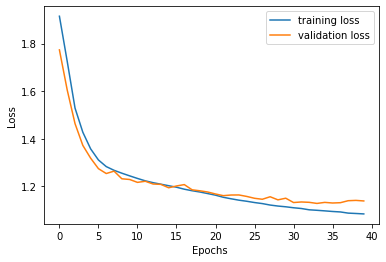

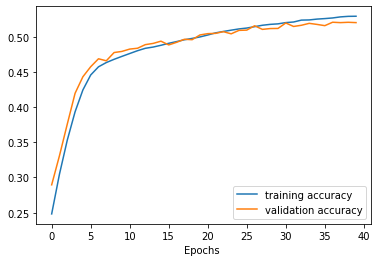

In [23]:
hist2= train_and_plot(
    lstm2,
    "/kaggle/working/checkpoints/lstm",
    x_train.reshape(x_train.shape),
    y_train_encoded,
    x_val.reshape(x_val.shape),
    y_val_encoded,
    epochs=EPOCHS
)

              precision    recall  f1-score   support

        8PSK       0.32      0.45      0.37     36000
      AM-DSB       0.47      0.79      0.59     36000
        BPSK       0.42      0.73      0.53     36000
       CPFSK       0.69      0.62      0.65     36000
        GFSK       0.75      0.68      0.72     36000
        PAM4       0.86      0.64      0.73     36000
       QAM16       0.42      0.29      0.34     36000
       QAM64       0.57      0.40      0.47     36000
        QPSK       0.34      0.31      0.32     36000
        WBFM       0.83      0.26      0.40     36000

    accuracy                           0.52    360000
   macro avg       0.57      0.52      0.51    360000
weighted avg       0.57      0.52      0.51    360000



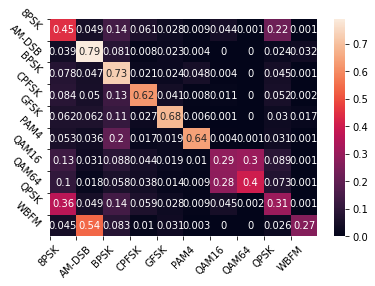

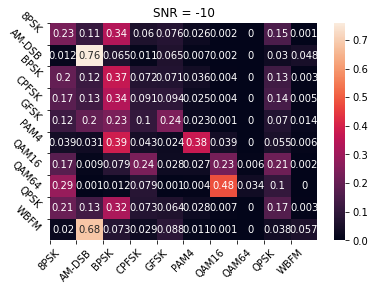

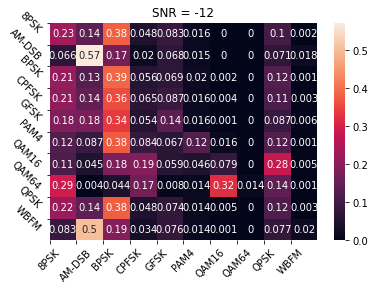

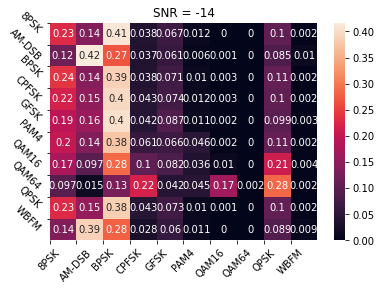

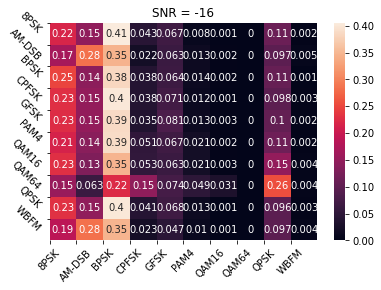

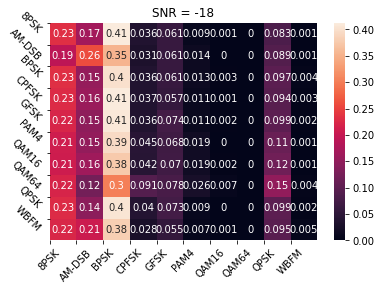

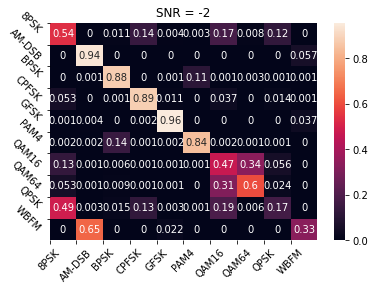

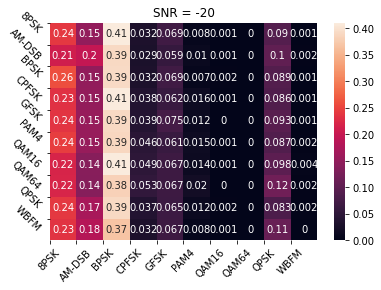

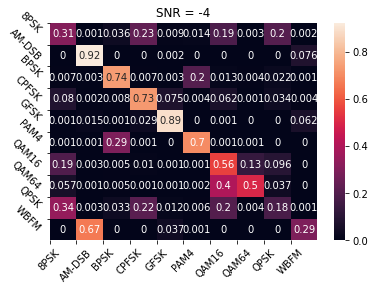

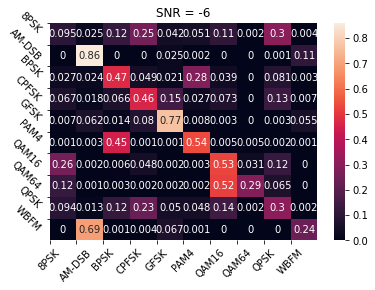

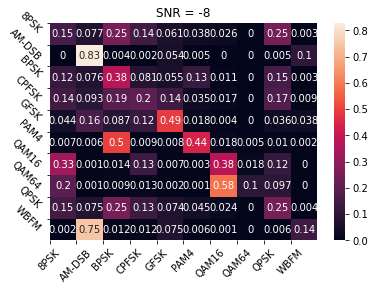

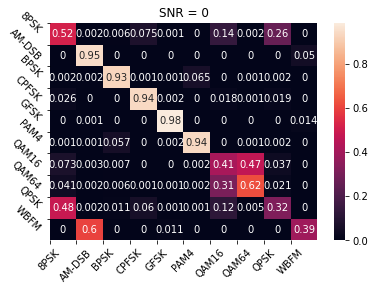

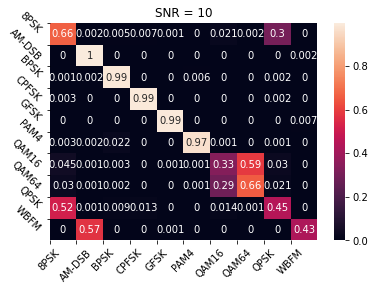

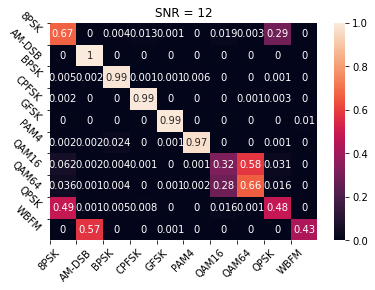

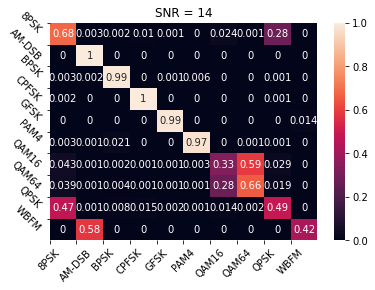

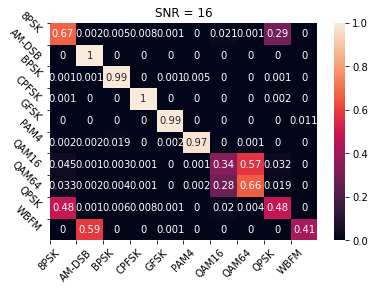

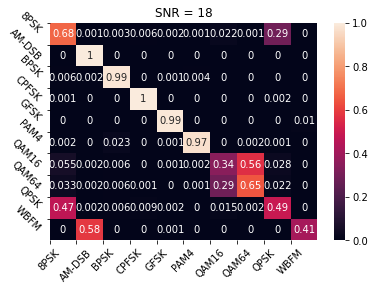

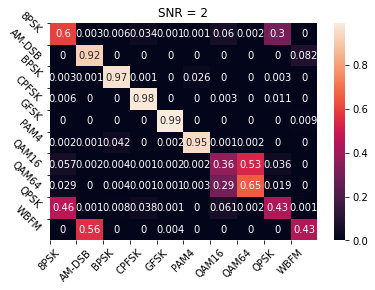

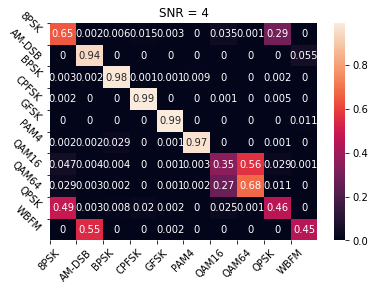

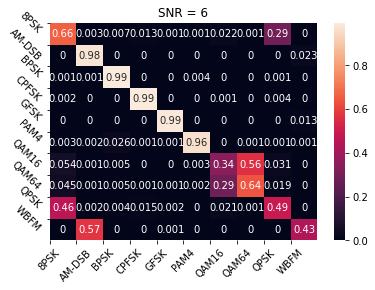

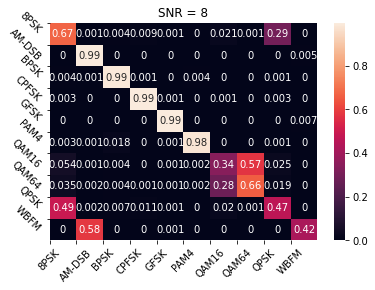

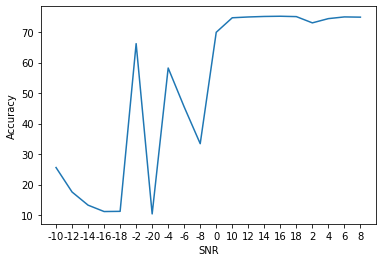

In [26]:
eval_model_lstm(lstm2,x_test,y_test,y_test_encoded)

# lstm diff

In [68]:
x = np.gradient(X,axis=-1)
lstm_diff=create_lstm1(x.shape[1:])

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 22)                13288     
_________________________________________________________________
dense_42 (Dense)             (None, 10)                230       
Total params: 13,518
Trainable params: 13,518
Non-trainable params: 0
_________________________________________________________________
None


In [69]:
x_train, x_val, x_test, y_train, y_val, y_test = split(x,y)
del x

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 114s 4ms/step - loss: 2.3027 - accuracy: 0.1001 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 114s 5ms/step - loss: 2.3027 - accuracy: 0.1000 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 110s 4ms/step - loss: 2.2617 - accuracy: 0.1313 - val_loss: 2.1722 - val_accuracy: 0.1688
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 104s 4ms/step - loss: 2.1478 - accuracy: 0.1751 - val_loss: 2.1297 - val_a

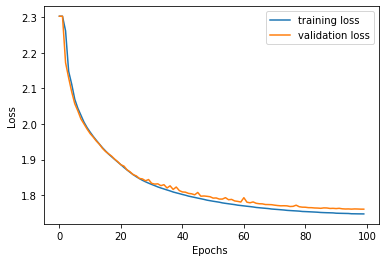

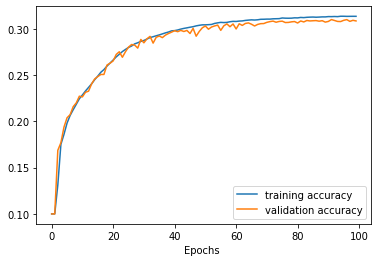

In [70]:
hist_diff= train_and_plot2(
    lstm_diff,
    "/kaggle/working/checkpoints/lstm",
    x_train.reshape(x_train.shape),
    y_train_encoded,
    x_val.reshape(x_val.shape),
    y_val_encoded,
    epochs=EPOCHS
)

              precision    recall  f1-score   support

        8PSK       0.15      0.07      0.09     36000
      AM-DSB       0.36      0.50      0.42     36000
        BPSK       0.15      0.14      0.14     36000
       CPFSK       0.32      0.59      0.41     36000
        GFSK       0.38      0.63      0.47     36000
        PAM4       0.47      0.46      0.46     36000
       QAM16       0.22      0.04      0.07     36000
       QAM64       0.26      0.51      0.34     36000
        QPSK       0.17      0.03      0.05     36000
        WBFM       0.29      0.13      0.18     36000

    accuracy                           0.31    360000
   macro avg       0.28      0.31      0.27    360000
weighted avg       0.28      0.31      0.27    360000



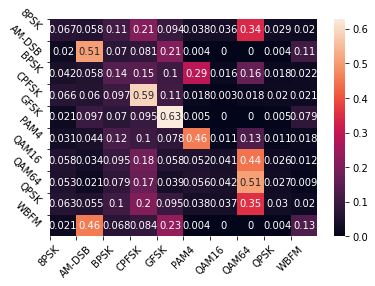

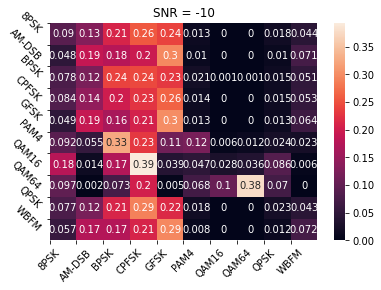

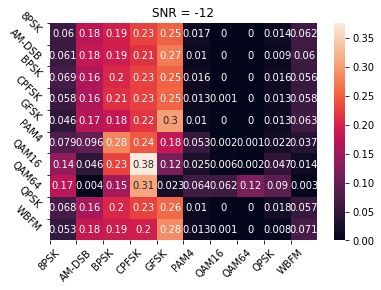

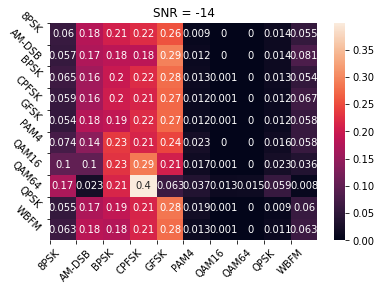

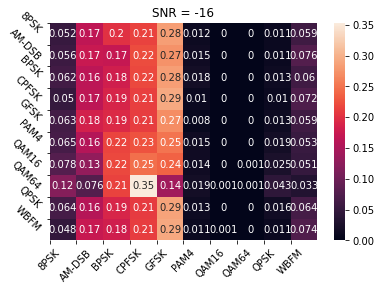

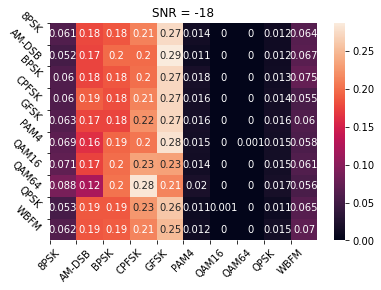

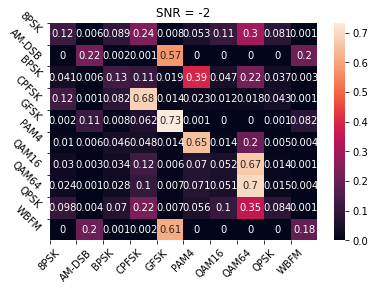

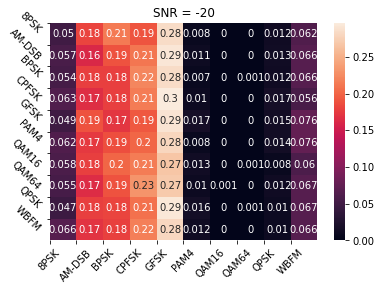

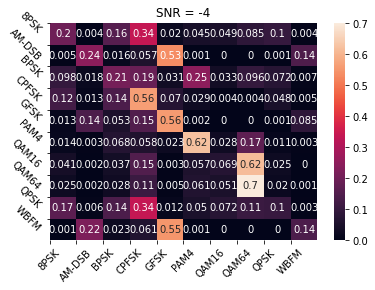

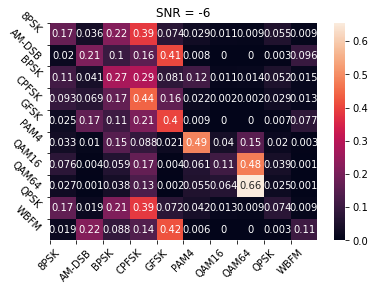

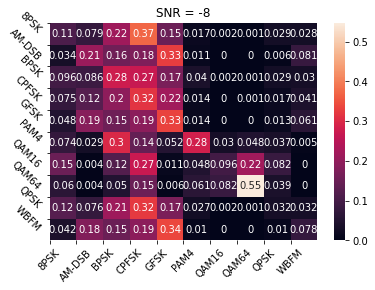

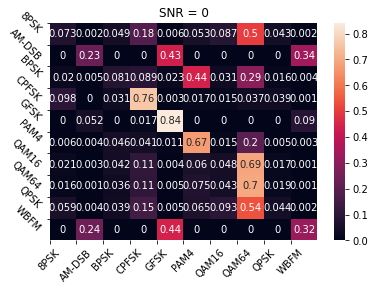

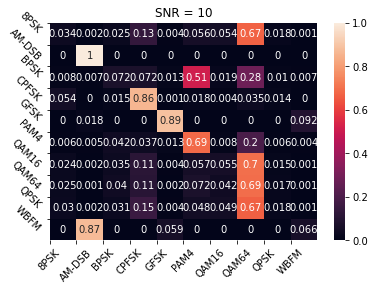

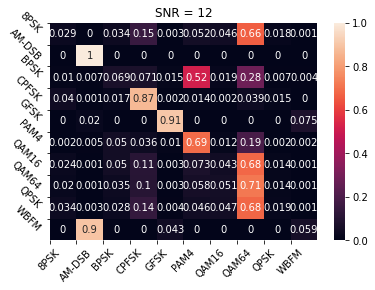

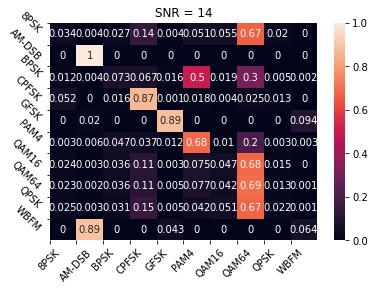

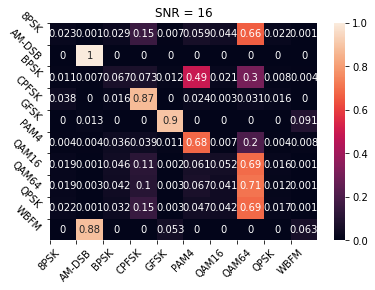

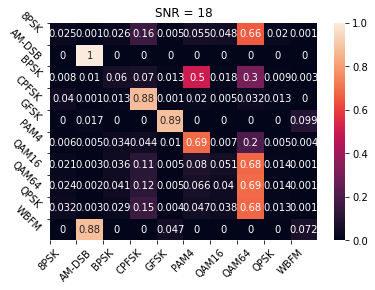

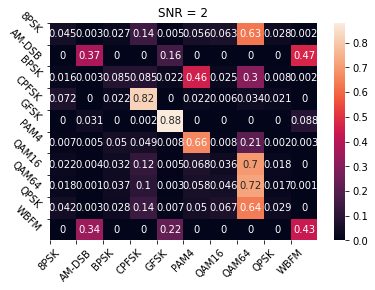

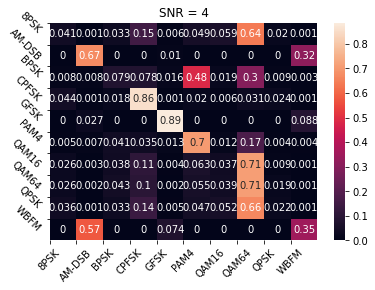

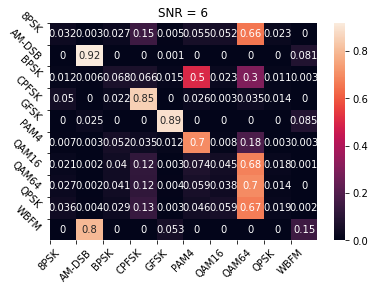

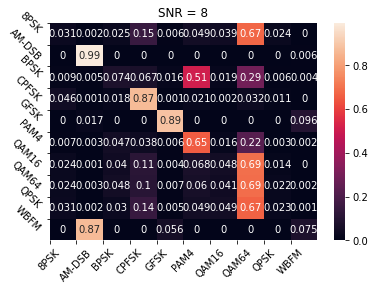

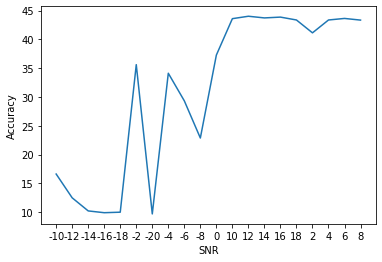

In [71]:
eval_model_lstm(lstm_diff,x_test,y_test,y_test_encoded)

# lstm int

In [57]:
x = cumulative_trapezoid(X)
lstm_int=create_lstm(x.shape[1:])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               131072    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                330       
Total params: 141,738
Trainable params: 141,738
Non-trainable params: 0
_________________________________________________________________
None


In [58]:
x_train, x_val, x_test, y_train, y_val, y_test = split(x,y)
del x

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 189s 7ms/step - loss: 1.7247 - accuracy: 0.3004 - val_loss: 1.6074 - val_accuracy: 0.3298
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 186s 7ms/step - loss: 1.5761 - accuracy: 0.3409 - val_loss: 1.5237 - val_accuracy: 0.3602
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 191s 8ms/step - loss: 1.5034 - accuracy: 0.3700 - val_loss: 1.4602 - val_accuracy: 0.3865
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 187s 7ms/step - loss: 1.4526 - accuracy: 0.3924 - val_loss: 1.4207 - val_a

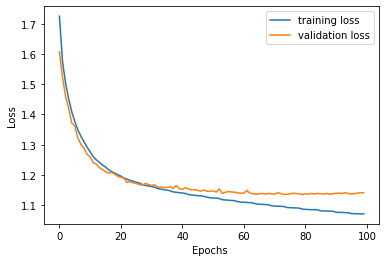

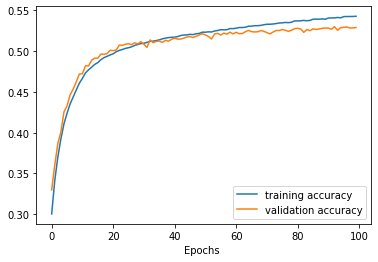

In [59]:
hist_int= train_and_plot2(
    lstm_int,
    "/kaggle/working/checkpoints/lstm",
    x_train.reshape(x_train.shape),
    y_train_encoded,
    x_val.reshape(x_val.shape),
    y_val_encoded,
    epochs=EPOCHS
)

              precision    recall  f1-score   support

        8PSK       0.26      0.52      0.35     36000
      AM-DSB       0.47      0.80      0.59     36000
        BPSK       0.57      0.65      0.60     36000
       CPFSK       0.66      0.62      0.64     36000
        GFSK       0.69      0.70      0.70     36000
        PAM4       0.85      0.67      0.75     36000
       QAM16       0.34      0.13      0.19     36000
       QAM64       0.53      0.57      0.55     36000
        QPSK       0.51      0.37      0.43     36000
        WBFM       0.85      0.25      0.39     36000

    accuracy                           0.53    360000
   macro avg       0.57      0.53      0.52    360000
weighted avg       0.57      0.53      0.52    360000



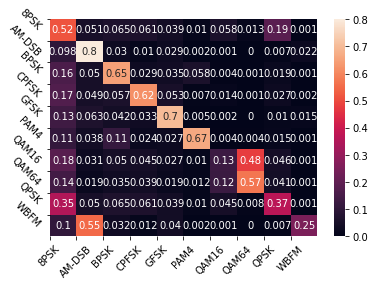

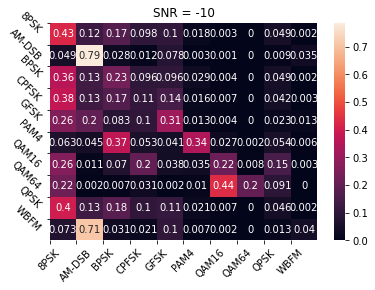

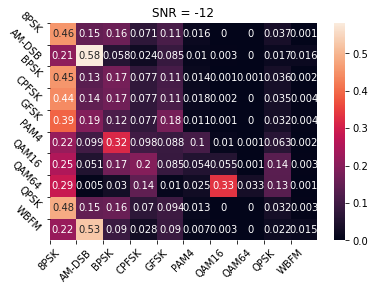

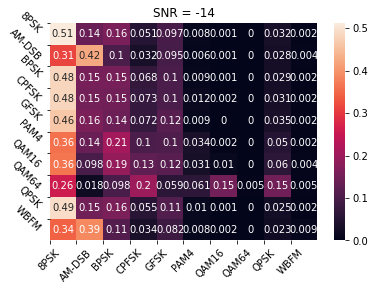

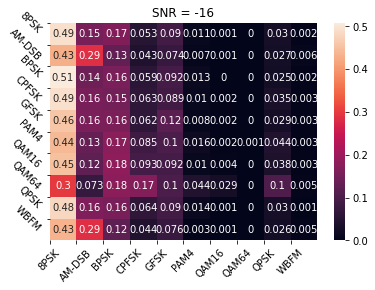

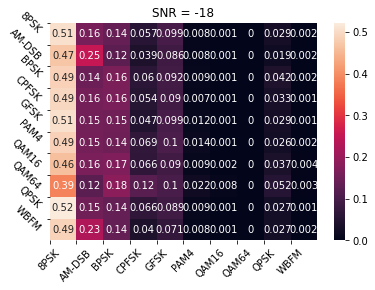

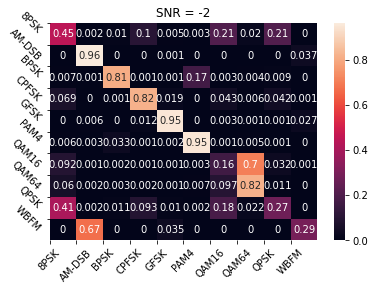

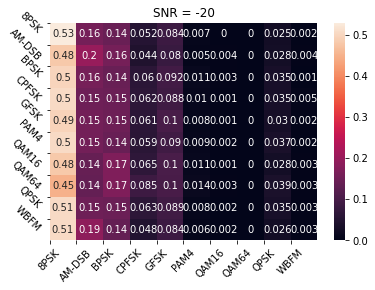

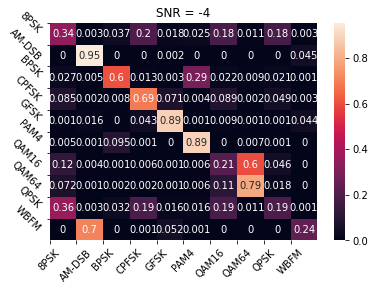

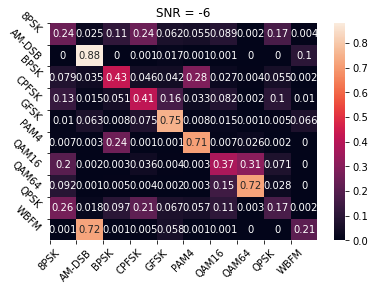

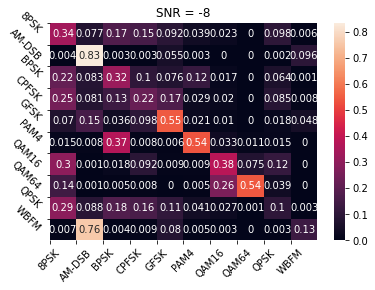

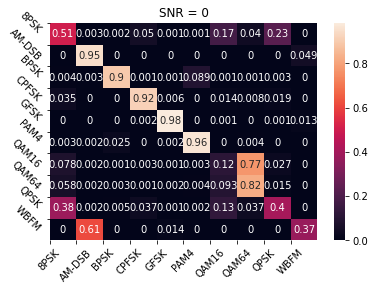

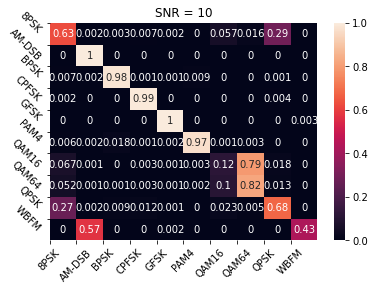

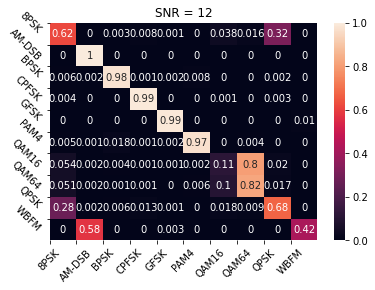

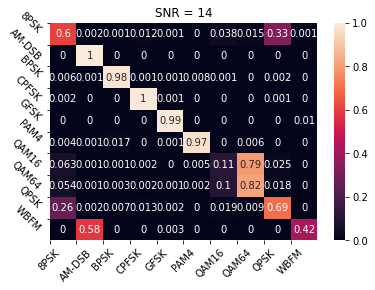

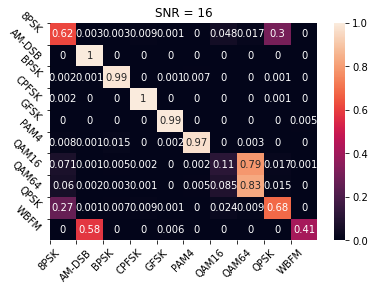

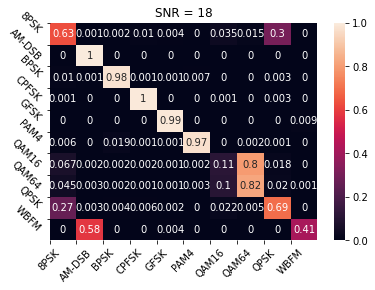

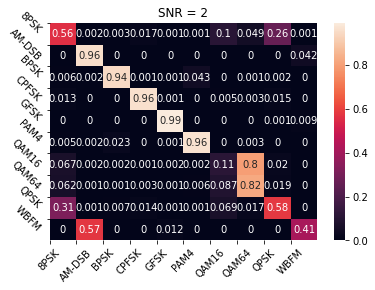

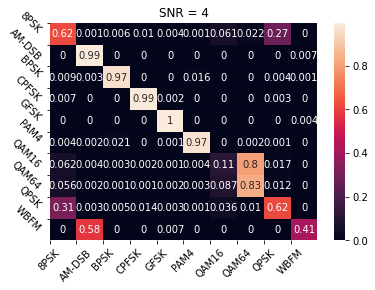

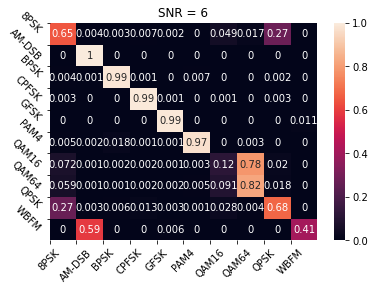

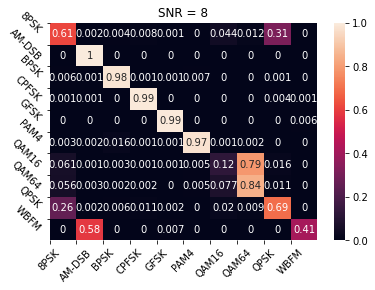

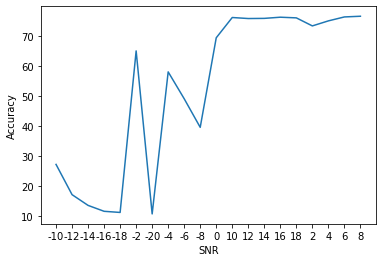

In [62]:
eval_model_lstm(lstm_int,x_test,y_test,y_test_encoded)

# raw and diff lstm

In [18]:
x = X_raw_diff
lstm_r_d=create_lstm2(x.shape[1:])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                330       
Total params: 437,802
Trainable params: 437,802
Non-trainable params: 0
________________________________________________

In [19]:
x_train, x_val, x_test, y_train, y_val, y_test = split(x,y)
del x

2023-01-21 22:55:23.629133: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 330s 13ms/step - loss: 1.9638 - accuracy: 0.2337 - val_loss: 1.8557 - val_accuracy: 0.2689
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 328s 13ms/step - loss: 1.7592 - accuracy: 0.2968 - val_loss: 1.6849 - val_accuracy: 0.3166
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 329s 13ms/step - loss: 1.6128 - accuracy: 0.3312 - val_loss: 1.5402 - val_accuracy: 0.3497
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 318s 13ms/step - loss: 1.4751 - accuracy: 0.3750 - val_loss: 1.3982 - v

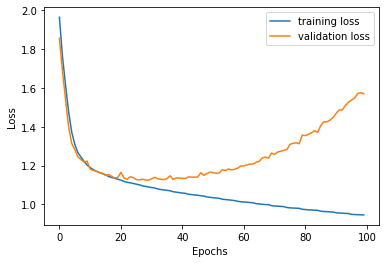

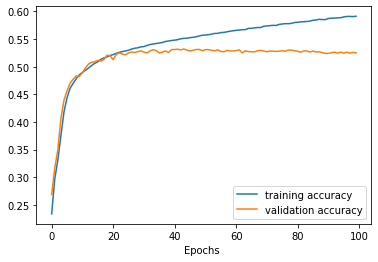

In [32]:
hist_r_d= train_and_plot2(
    lstm_r_d,
    "/kaggle/working/checkpoints/lstm",
    x_train.reshape(x_train.shape),
    y_train_encoded,
    x_val.reshape(x_val.shape),
    y_val_encoded,
    epochs=EPOCHS
)

              precision    recall  f1-score   support

        8PSK       0.29      0.45      0.35     36000
      AM-DSB       0.46      0.80      0.58     36000
        BPSK       0.51      0.64      0.57     36000
       CPFSK       0.63      0.62      0.63     36000
        GFSK       0.75      0.67      0.71     36000
        PAM4       0.83      0.67      0.74     36000
       QAM16       0.39      0.26      0.31     36000
       QAM64       0.54      0.44      0.48     36000
        QPSK       0.43      0.42      0.43     36000
        WBFM       0.83      0.26      0.40     36000

    accuracy                           0.52    360000
   macro avg       0.57      0.52      0.52    360000
weighted avg       0.57      0.52      0.52    360000



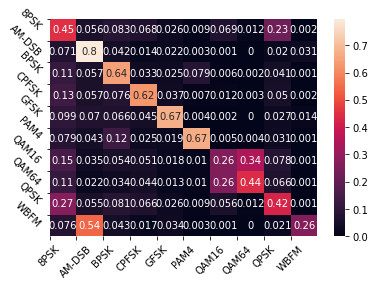

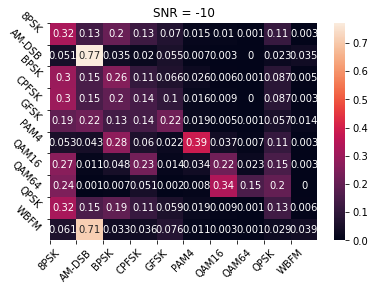

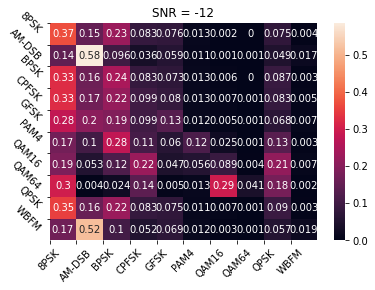

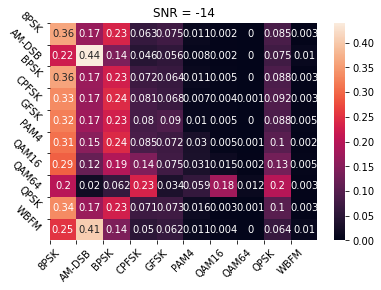

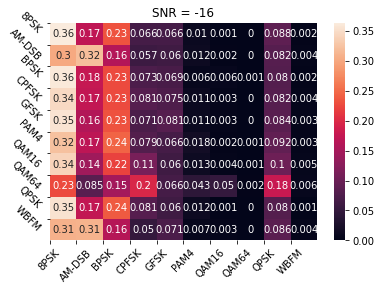

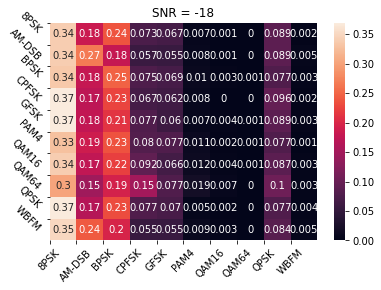

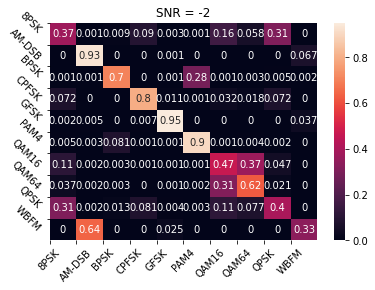

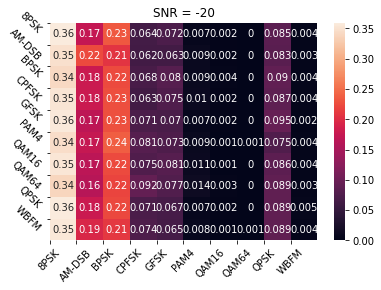

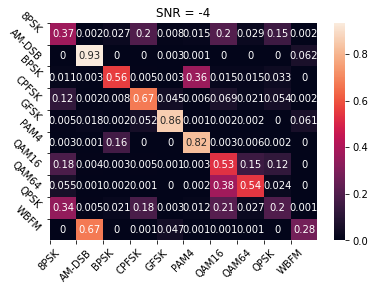

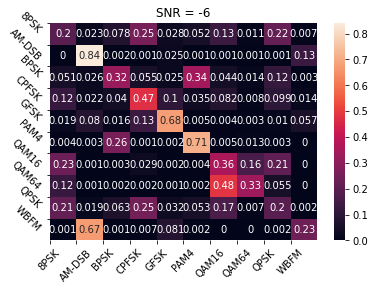

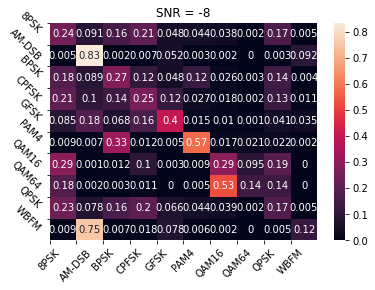

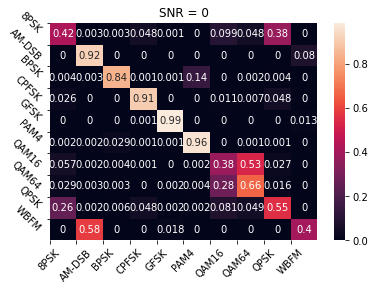

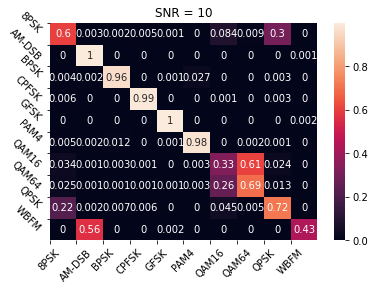

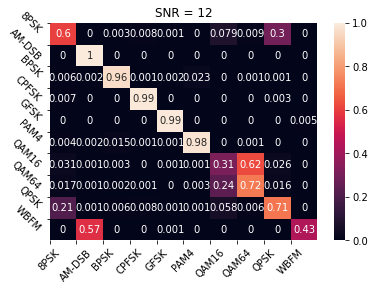

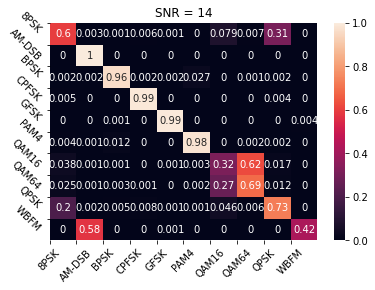

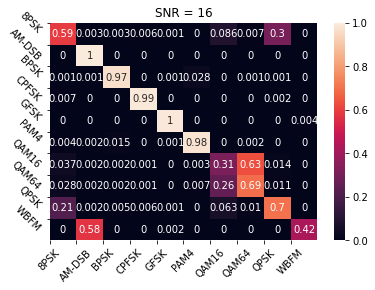

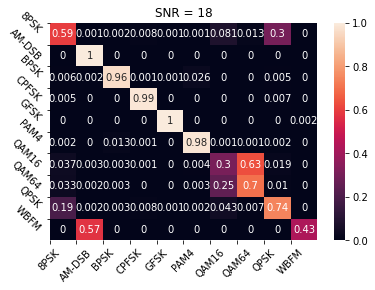

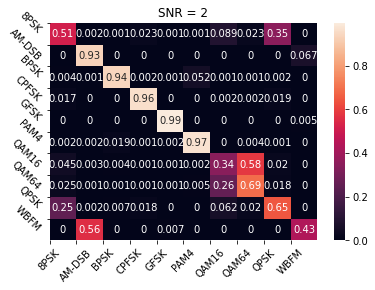

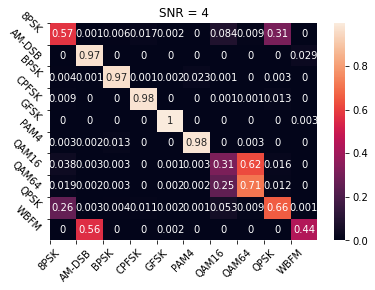

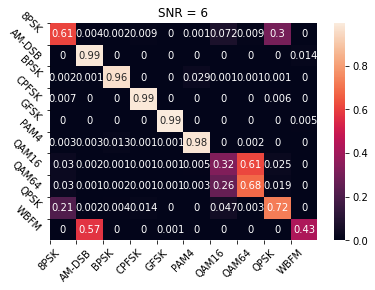

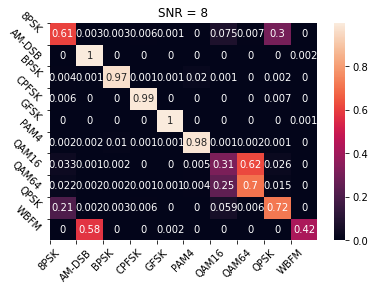

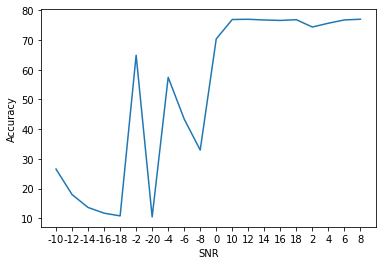

In [33]:
eval_model_lstm(lstm_r_d,x_test,y_test,y_test_encoded)

# raw and integral lstm

In [12]:
x = X_raw_int
lstm_r_i=create_lstm2(x.shape[1:])

2023-01-22 10:05:12.286202: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 437,802
Trainable params: 437,802
Non-trainable params: 0
__________________________________________________

In [13]:
x_train, x_val, x_test, y_train, y_val, y_test = split(x,y)
del x

In [18]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(y_test[:,0].reshape(-1,1))
y_test_encoded = encoder.transform(y_test[:,0].reshape(-1,1))
y_train_encoded = encoder.transform(y_train[:,0].reshape(-1,1))
y_val_encoded = encoder.transform(y_val[:,0].reshape(-1,1))
y_test_encoded.shape

(360000, 10)

2023-01-22 10:06:33.547403: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 361s 14ms/step - loss: 1.6979 - accuracy: 0.3072 - val_loss: 1.5483 - val_accuracy: 0.3428
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 348s 14ms/step - loss: 1.4975 - accuracy: 0.3727 - val_loss: 1.4132 - val_accuracy: 0.4121
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 356s 14ms/step - loss: 1.3843 - accuracy: 0.4229 - val_loss: 1.3189 - val_accuracy: 0.4525
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 344s 14ms/step - loss: 1.3083 - accuracy: 0.4557 - val_loss: 1.2720 - v

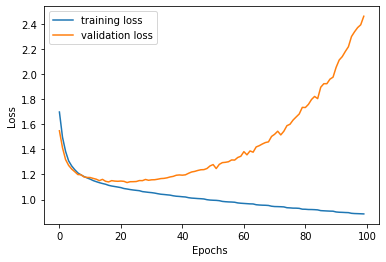

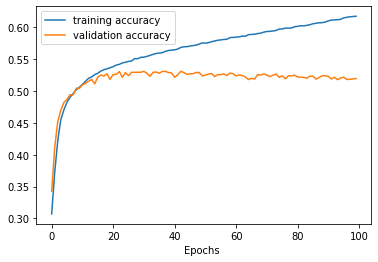

In [19]:
hist_r_i= train_and_plot2(
    lstm_r_i,
    "/kaggle/working/checkpoints/lstm",
    x_train.reshape(x_train.shape),
    y_train_encoded,
    x_val.reshape(x_val.shape),
    y_val_encoded,
    epochs=EPOCHS
)

              precision    recall  f1-score   support

        8PSK       0.26      0.51      0.35     36000
      AM-DSB       0.46      0.80      0.58     36000
        BPSK       0.59      0.62      0.60     36000
       CPFSK       0.70      0.58      0.63     36000
        GFSK       0.67      0.69      0.68     36000
        PAM4       0.81      0.66      0.73     36000
       QAM16       0.39      0.26      0.31     36000
       QAM64       0.48      0.41      0.44     36000
        QPSK       0.50      0.37      0.42     36000
        WBFM       0.80      0.26      0.39     36000

    accuracy                           0.52    360000
   macro avg       0.57      0.52      0.51    360000
weighted avg       0.57      0.52      0.51    360000



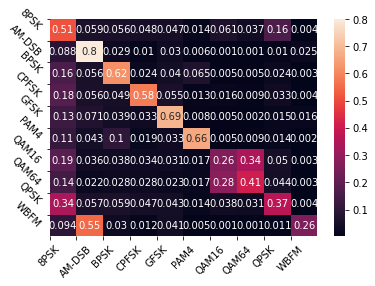

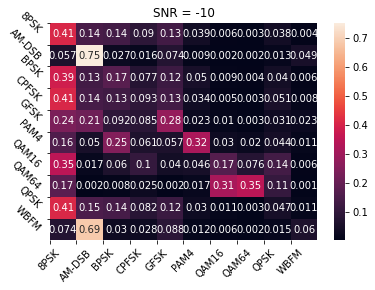

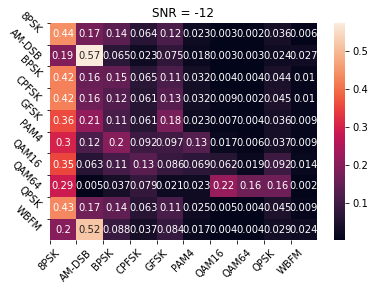

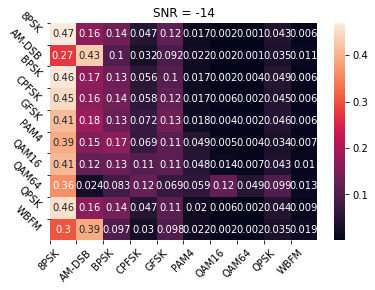

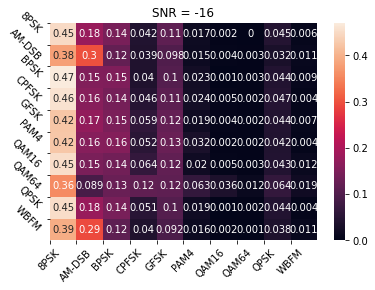

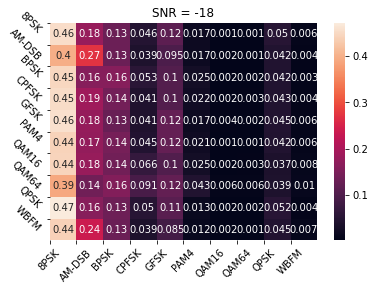

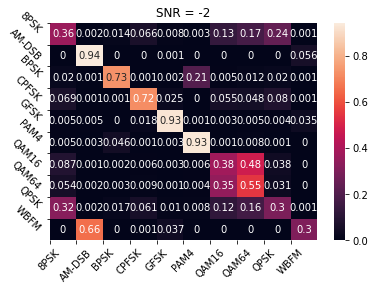

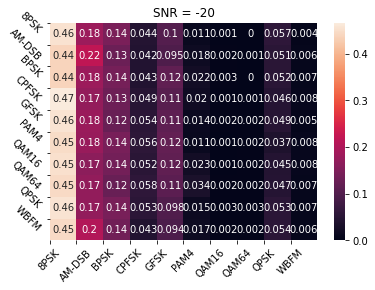

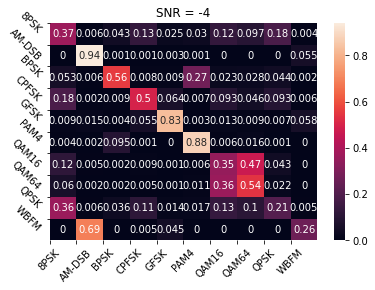

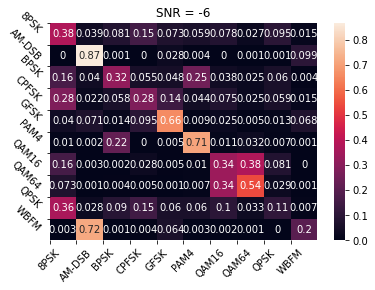

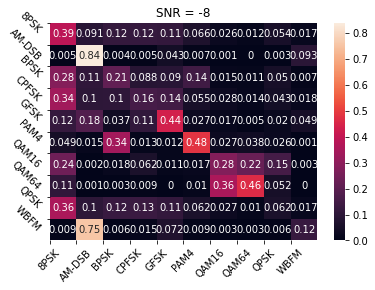

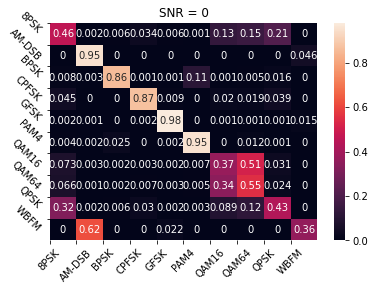

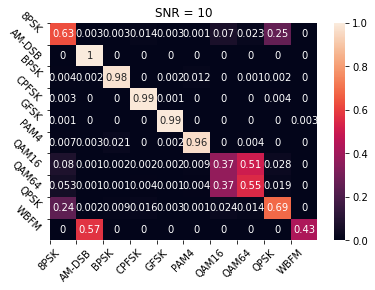

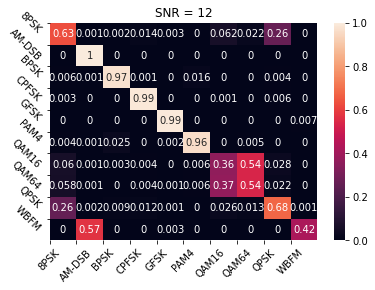

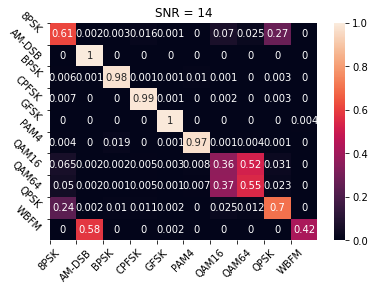

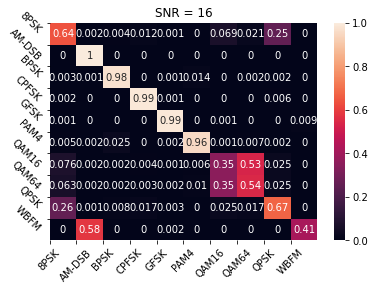

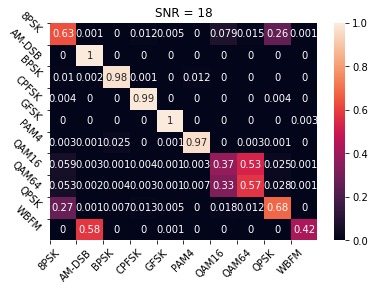

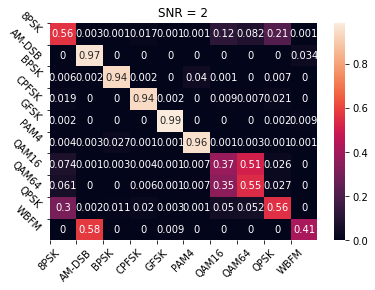

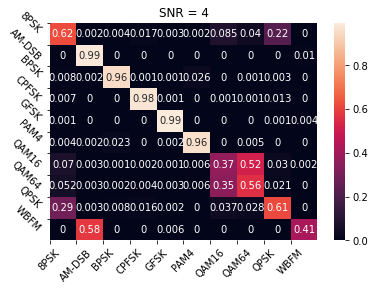

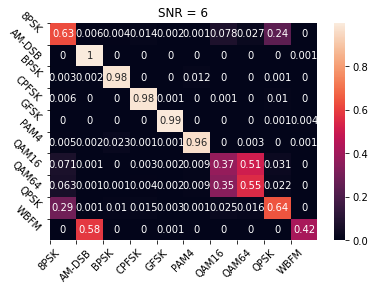

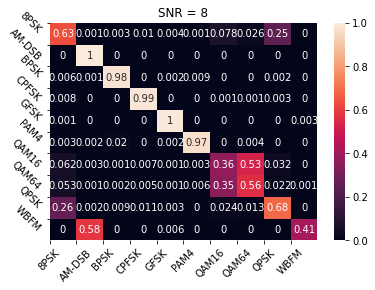

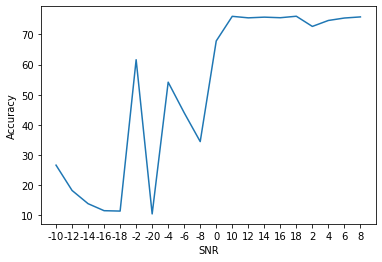

In [20]:
eval_model_lstm(lstm_r_i,x_test,y_test,y_test_encoded)

# diff and integral lstm

In [16]:
X_diff = np.gradient(X,axis=-1)
X_int = np.zeros_like(X)
X_int[:,:,:-1] = np.array(cumulative_trapezoid(X))
X_diff_int = np.concatenate((X_diff,X_int),axis=1)

X_all = np.concatenate((X,X_diff,X_int),axis=1)
x = X_diff_int
lstm_d_i=create_lstm2(x.shape[1:])

2023-01-25 07:05:14.274708: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 437,802
Trainable params: 437,802
Non-trainable params: 0
__________________________________________________

In [18]:

del X_diff_int

del X_all

In [19]:
x_train, x_val, x_test, y_train, y_val, y_test = split(x,y)
del x

In [20]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(y_test[:,0].reshape(-1,1))
y_test_encoded = encoder.transform(y_test[:,0].reshape(-1,1))
y_train_encoded = encoder.transform(y_train[:,0].reshape(-1,1))
y_val_encoded = encoder.transform(y_val[:,0].reshape(-1,1))
y_test_encoded.shape

(360000, 10)

2023-01-25 07:09:10.853251: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 330s 13ms/step - loss: 1.7065 - accuracy: 0.3041 - val_loss: 1.5806 - val_accuracy: 0.3389
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 323s 13ms/step - loss: 1.5403 - accuracy: 0.3548 - val_loss: 1.4877 - val_accuracy: 0.3735
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 322s 13ms/step - loss: 1.4579 - accuracy: 0.3903 - val_loss: 1.4278 - val_accuracy: 0.4097
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 322s 13ms/step - loss: 1.3843 - accuracy: 0.4218 - val_loss: 1.3358 - v

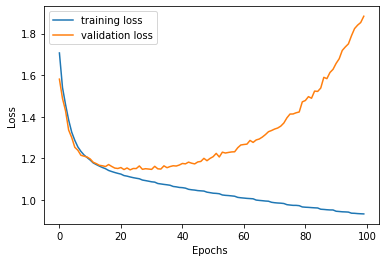

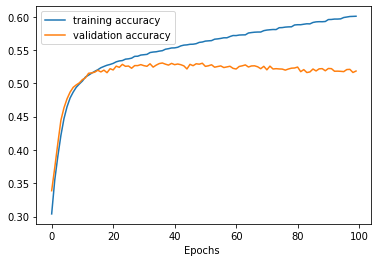

In [32]:
hist_r_i= train_and_plot2(
    lstm_d_i,
    "/kaggle/working/checkpoints/lstm",
    x_train.reshape(x_train.shape),
    y_train_encoded,
    x_val.reshape(x_val.shape),
    y_val_encoded,
    epochs=EPOCHS
)

              precision    recall  f1-score   support

        8PSK       0.27      0.50      0.35     36000
      AM-DSB       0.45      0.80      0.57     36000
        BPSK       0.63      0.61      0.62     36000
       CPFSK       0.75      0.57      0.65     36000
        GFSK       0.67      0.69      0.68     36000
        PAM4       0.83      0.66      0.73     36000
       QAM16       0.37      0.24      0.29     36000
       QAM64       0.50      0.45      0.47     36000
        QPSK       0.45      0.41      0.43     36000
        WBFM       0.79      0.26      0.40     36000

    accuracy                           0.52    360000
   macro avg       0.57      0.52      0.52    360000
weighted avg       0.57      0.52      0.52    360000



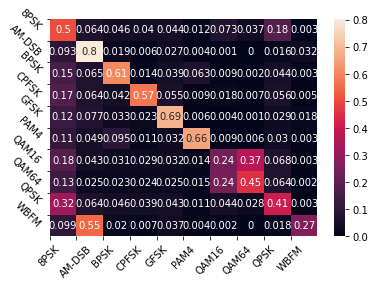

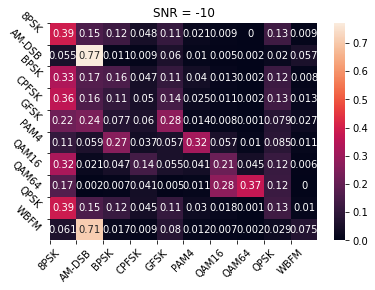

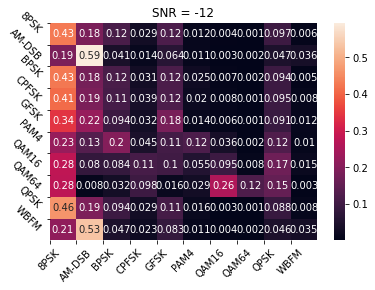

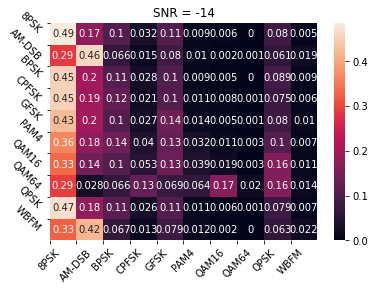

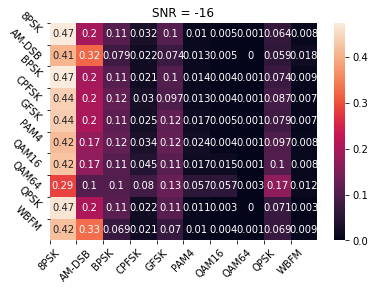

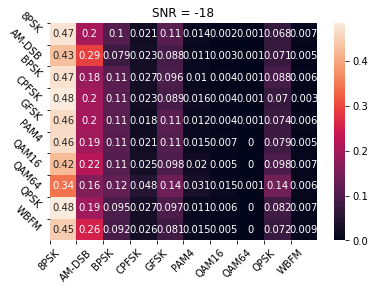

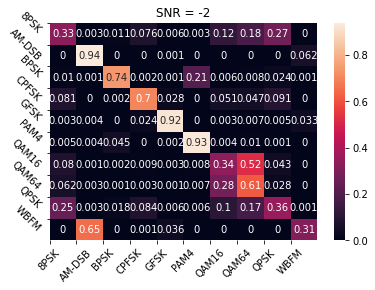

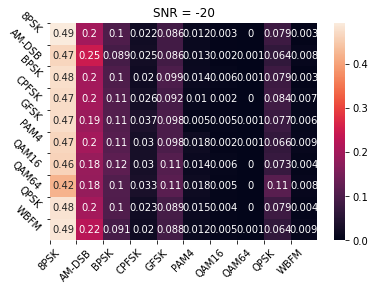

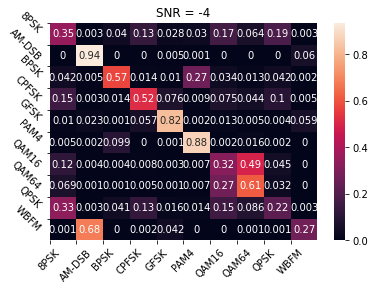

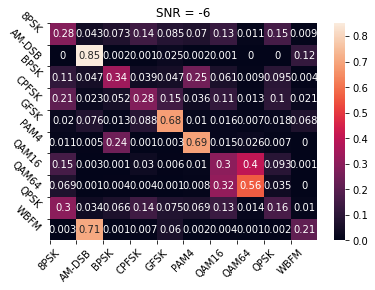

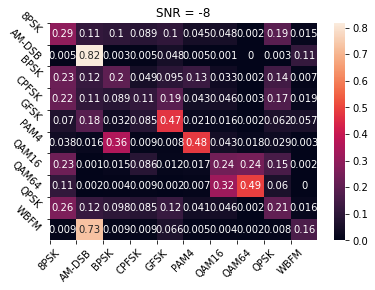

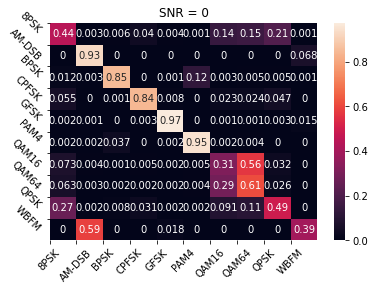

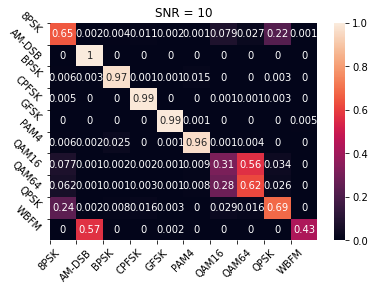

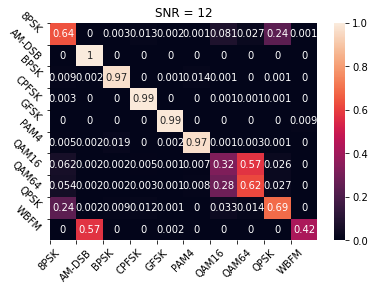

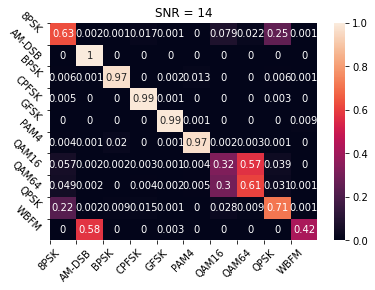

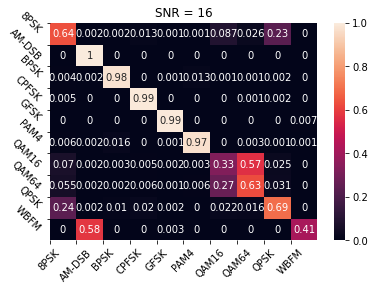

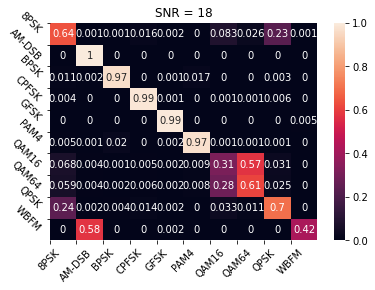

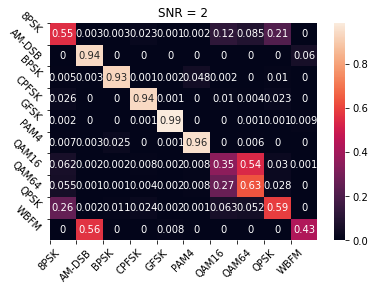

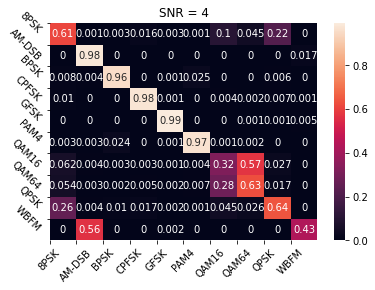

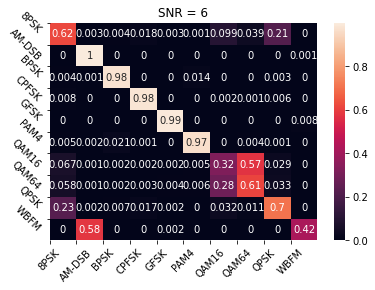

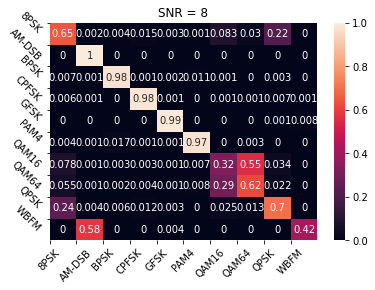

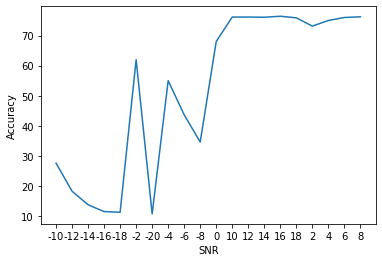

In [35]:
eval_model_lstm(lstm_d_i,x_test,y_test,y_test_encoded)

# all

In [ ]:
X_diff = np.gradient(X,axis=-1)
X_int = np.zeros_like(X)
X_int[:,:,:-1] = np.array(cumulative_trapezoid(X))

X_raw_diff = np.concatenate((X,X_diff),axis=1)
X_raw_int = np.concatenate((X,X_int),axis=1)
X_diff_int = np.concatenate((X_diff,X_int),axis=1)

X_all = np.concatenate((X,X_diff,X_int),axis=1)
x = X_all
lstm_a=create_lstm2(x.shape[1:])

In [15]:
del X_diff
del X_int

del X_raw_diff
del X_raw_int
del X_diff_int

del X_all

NameError: name 'X_diff' is not defined

In [17]:
x_train, x_val, x_test, y_train, y_val, y_test = split(x,y)
del x

In [18]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(y_test[:,0].reshape(-1,1))
y_test_encoded = encoder.transform(y_test[:,0].reshape(-1,1))
y_train_encoded = encoder.transform(y_train[:,0].reshape(-1,1))
y_val_encoded = encoder.transform(y_val[:,0].reshape(-1,1))
y_test_encoded.shape

(360000, 10)

In [ ]:
hist_r_i= train_and_plot2(
    lstm_a,
    "/kaggle/working/checkpoints/lstm",
    x_train.reshape(x_train.shape),
    y_train_encoded,
    x_val.reshape(x_val.shape),
    y_val_encoded,
    epochs=EPOCHS
)

In [ ]:
eval_model_lstm(lstm_a,x_test,y_test,y_test_encoded)